## 1. Setup and configuration

This section imports dependencies, sets seeds, and defines a configuration block. It is designed to run on **CPU-only Windows 11** with `num_workers = 0`.

In [38]:

import os
import math
import time
import random
from pathlib import Path
from typing import Dict, Any, Tuple

import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models

import matplotlib.pyplot as plt

# Optional: SciPy for .mat loading. If missing, install via: pip install scipy
try:
    import scipy.io as sio
except ImportError as e:
    raise ImportError("scipy is required to read .mat ground-truth files. "
                      "Install it with: pip install scipy") from e

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available (not used here):", torch.cuda.is_available())


PyTorch version: 2.9.0+cpu
Torchvision version: 0.24.0+cpu
CUDA available (not used here): False


In [39]:

# Reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seeds set to:", SEED)


Seeds set to: 42


In [40]:

# Configuration
class Config:
    dataset_root = r"C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech"

    partA_train_images = os.path.join(dataset_root, "part_A/train_data/images")
    partA_train_gt     = os.path.join(dataset_root, "part_A/train_data/ground-truth")
    partB_train_images = os.path.join(dataset_root, "part_B/train_data/images")
    partB_train_gt     = os.path.join(dataset_root, "part_B/train_data/ground-truth")

    # Device: force CPU
    use_cpu = True
    device = torch.device("cpu")

    # Data loading & training params
    batch_size   = 2
    num_workers  = 0  # Windows-friendly
    learning_rate = 1e-5
    weight_decay  = 5e-4
    epochs_demo   = 10  # Demo only; increase to 50/100/300 for real training.

    # Optional limit on max image side (longer side); None keeps original size
    img_max_side = 512  # or None

    # Gradient accumulation steps
    grad_accum_steps = 1

    # Artifacts
    save_path   = "csrnet_weights.pth"
    losses_path = "csrnet_losses.npz"

CFG = Config()

print("Using device:", CFG.device)
print("Part A train images:", CFG.partA_train_images)
print("Part B train images:", CFG.partB_train_images)


Using device: cpu
Part A train images: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A/train_data/images
Part B train images: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B/train_data/images


## 2. Data exploration and visualization

We count images and `.mat` ground-truth files for Part A and Part B, then visualize random samples: RGB image, density map heatmap, and count (sum of density).

In [41]:

def count_files(images_dir: str, gt_dir: str) -> Tuple[int, int]:
    img_dir = Path(images_dir)
    gt_dir_p = Path(gt_dir)
    n_imgs = len(sorted(img_dir.glob("*.jpg")))
    # Ground-truth files are .mat (e.g., GT_IMG_1.mat)
    n_gts = len(sorted(gt_dir_p.glob("*.mat")))
    return n_imgs, n_gts

# Sanity check
for path in [CFG.partA_train_images, CFG.partA_train_gt,
             CFG.partB_train_images, CFG.partB_train_gt]:
    if not Path(path).exists():
        print(f"WARNING: Path does not exist: {path}")
        print("Please update Config.dataset_root to the correct directory.")

partA_imgs, partA_gts = count_files(CFG.partA_train_images, CFG.partA_train_gt)
partB_imgs, partB_gts = count_files(CFG.partB_train_images, CFG.partB_train_gt)

print("Train set summary (Part A / Part B):")
print("-" * 60)
print(f"{'Subset':<10} | {'#Images':>8} | {'#GT (mat)':>10}")
print("-" * 60)
print(f"{'Part A':<10} | {partA_imgs:>8d} | {partA_gts:>10d}")
print(f"{'Part B':<10} | {partB_imgs:>8d} | {partB_gts:>10d}")
print("-" * 60)


Train set summary (Part A / Part B):
------------------------------------------------------------
Subset     |  #Images |  #GT (mat)
------------------------------------------------------------
Part A     |      300 |        300
Part B     |      400 |        400
------------------------------------------------------------


In [42]:

def load_image_rgb_01_basic(path: str) -> np.ndarray:
    """RGB image in [0,1] as float32, no resizing (for exploration)."""
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = rgb.astype(np.float32) / 255.0
    return rgb

def load_points_from_mat(mat_path: str) -> np.ndarray:
    """Load head annotations (x, y) from ShanghaiTech .mat file."""
    mat = sio.loadmat(mat_path)
    if "image_info" not in mat:
        raise KeyError(f"'image_info' not found in {mat_path}")
    info = mat["image_info"]

    # Standard ShanghaiTech structure:
    # mat['image_info'][0,0][0,0][0] -> (N, 2)
    pts = None
    try:
        pts = info[0, 0][0, 0][0]
    except Exception:
        # Fallback: search recursively for an (N,2) array
        def find_pts(obj):
            if isinstance(obj, np.ndarray):
                if obj.ndim == 2 and obj.shape[1] == 2:
                    return obj
                for item in obj.flat:
                    res = find_pts(item)
                    if res is not None:
                        return res
            return None
        pts = find_pts(info)

    if pts is None:
        raise ValueError(f"Could not extract points from {mat_path}")

    pts = pts.astype(np.float32)
    return pts

def generate_density_from_points(points: np.ndarray, h: int, w: int, sigma: float = 4.0) -> np.ndarray:
    """Create a density map from point annotations using a Gaussian kernel.


    - points: Nx2 array (x, y) in image coordinates (1-based or 0-based).

    - h, w: desired output height and width.

    - sigma: Gaussian standard deviation.

    """
    density = np.zeros((h, w), dtype=np.float32)
    if points.size == 0:
        return density

    # Points may be 1-based; convert to 0-based indices
    for x, y in points:
        x = float(x)
        y = float(y)
        # swap to row, col (y, x)
        ix = int(round(x - 1))
        iy = int(round(y - 1))
        if 0 <= iy < h and 0 <= ix < w:
            density[iy, ix] += 1.0

    # Apply Gaussian blur; this approximately preserves the sum
    if density.sum() > 0:
        density = cv2.GaussianBlur(density, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_CONSTANT)
    return density

def overlay_density_on_image(img_rgb_01: np.ndarray,
                             density_map: np.ndarray,
                             alpha: float = 0.6,
                             cmap: str = "jet") -> np.ndarray:
    """Overlay a density heatmap onto an RGB image for visualization."""
    h_img, w_img, _ = img_rgb_01.shape
    h_dm, w_dm = density_map.shape

    if (h_img, w_img) != (h_dm, w_dm):
        dm_resized = cv2.resize(density_map, (w_img, h_img), interpolation=cv2.INTER_CUBIC)
    else:
        dm_resized = density_map

    dm_norm = dm_resized.copy()
    if dm_norm.max() > 0:
        dm_norm = dm_norm / dm_norm.max()

    heatmap = plt.get_cmap(cmap)(dm_norm)[:, :, :3]
    overlay = (1 - alpha) * img_rgb_01 + alpha * heatmap
    overlay = np.clip(overlay, 0.0, 1.0)
    return overlay

def gt_mat_from_img(img_path: Path, gt_dir: str) -> Path:
    """Map IMG_123.jpg -> ground_truth/GT_IMG_123.mat"""
    return Path(gt_dir) / f"GT_{img_path.stem}.mat"


Random samples from Part A train:
--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\images\IMG_150.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_150.mat
Image shape: (450, 970, 3), dtype: float32
Density shape: (450, 970), dtype: float32, min: 0.0000, max: 0.0205
Approx. crowd count (sum of density): 984.57  | #points: 989


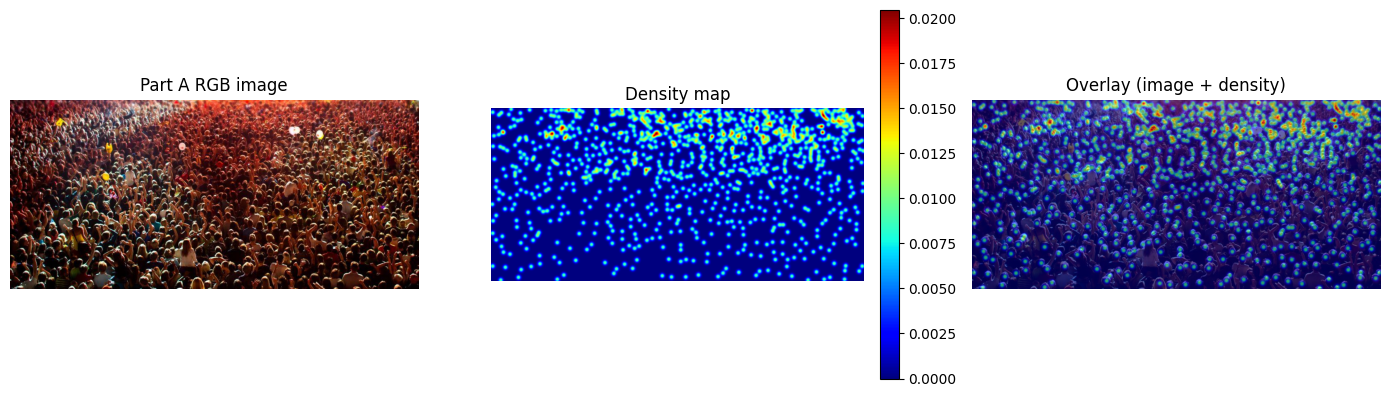

--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\images\IMG_11.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_11.mat
Image shape: (686, 1024, 3), dtype: float32
Density shape: (686, 1024), dtype: float32, min: 0.0000, max: 0.0309
Approx. crowd count (sum of density): 248.00  | #points: 248


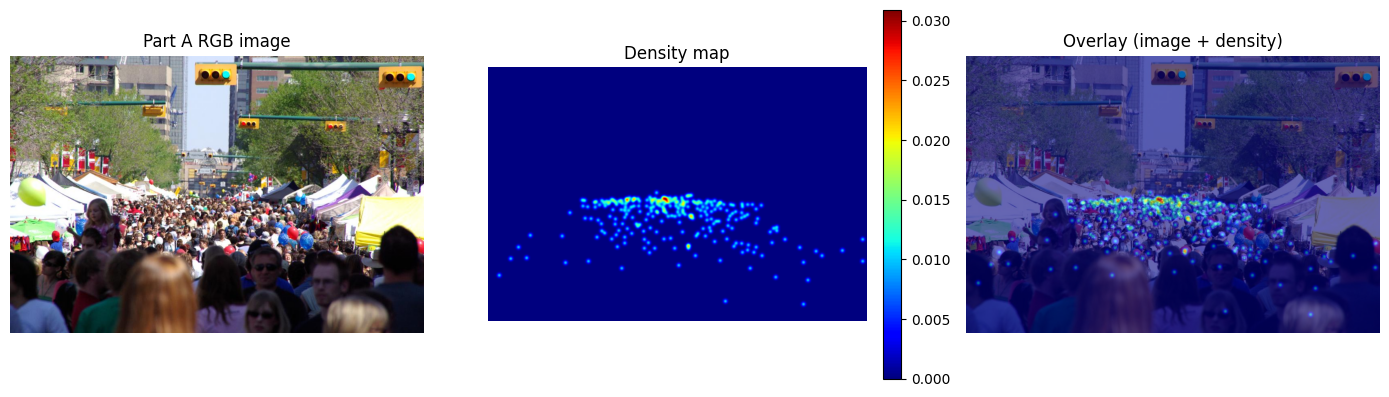

--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\images\IMG_225.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_225.mat
Image shape: (549, 1024, 3), dtype: float32
Density shape: (549, 1024), dtype: float32, min: 0.0000, max: 0.0199
Approx. crowd count (sum of density): 473.96  | #points: 476


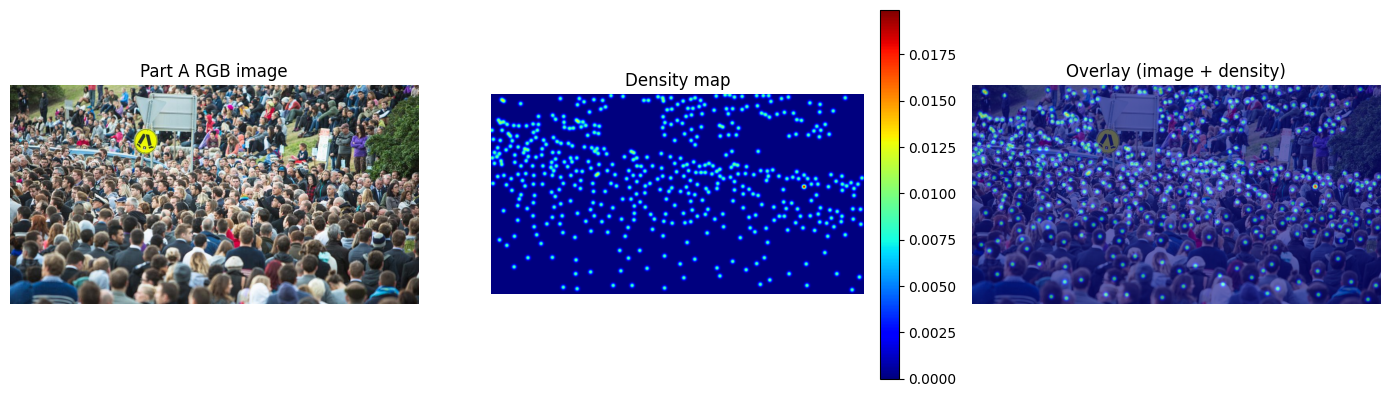


Random samples from Part B train:
--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\images\IMG_211.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\ground-truth\GT_IMG_211.mat
Image shape: (768, 1024, 3), dtype: float32
Density shape: (768, 1024), dtype: float32, min: 0.0000, max: 0.0100
Approx. crowd count (sum of density): 32.87  | #points: 33


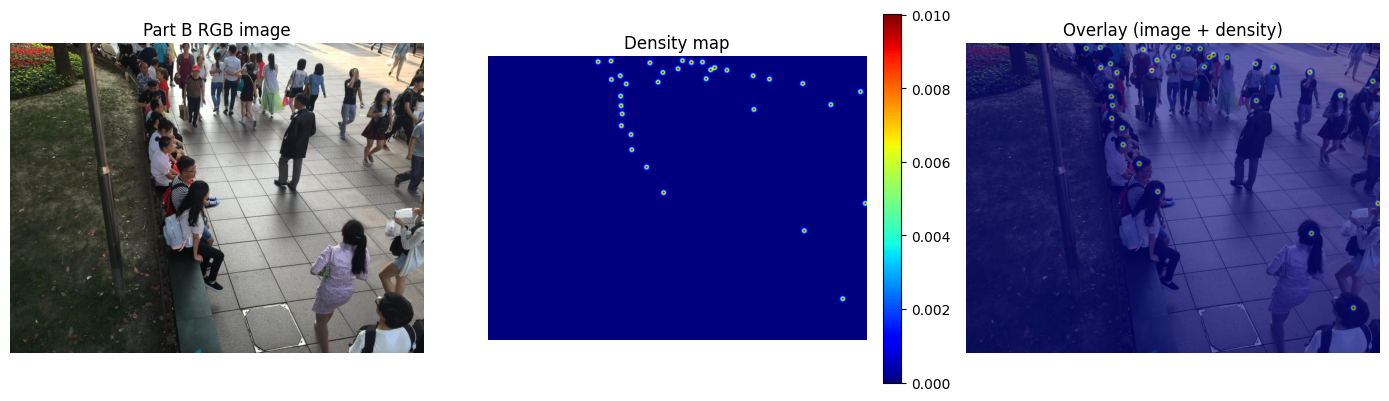

--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\images\IMG_201.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\ground-truth\GT_IMG_201.mat
Image shape: (768, 1024, 3), dtype: float32
Density shape: (768, 1024), dtype: float32, min: 0.0000, max: 0.0099
Approx. crowd count (sum of density): 29.71  | #points: 30


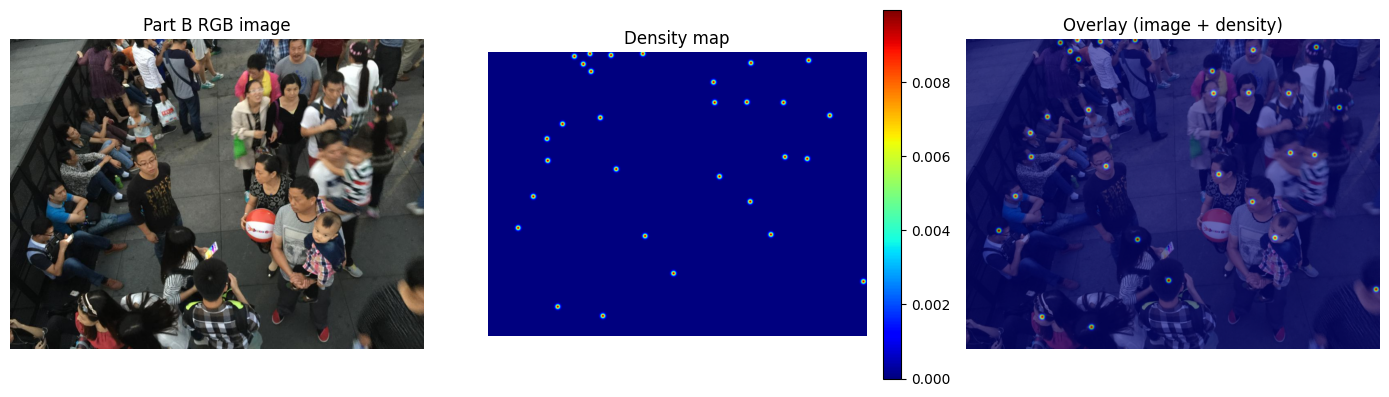

--------------------------------------------------------------------------------
Image: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\images\IMG_163.jpg
GT mat: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\ground-truth\GT_IMG_163.mat
Image shape: (768, 1024, 3), dtype: float32
Density shape: (768, 1024), dtype: float32, min: 0.0000, max: 0.0221
Approx. crowd count (sum of density): 165.49  | #points: 166


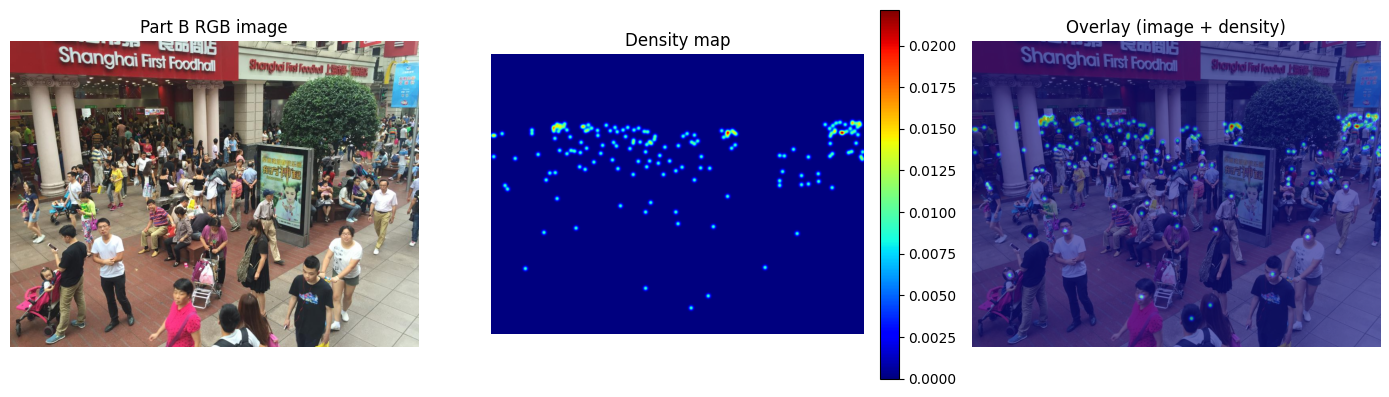

In [43]:

def show_random_samples(images_dir: str, gt_dir: str, num_samples: int = 3, title_prefix: str = ""):
    img_paths = sorted(Path(images_dir).glob("*.jpg"))
    if len(img_paths) == 0:
        print(f"No images found in {images_dir}")
        return

    chosen = random.sample(img_paths, min(num_samples, len(img_paths)))
    for img_path in chosen:
        mat_path = gt_mat_from_img(img_path, gt_dir)
        if not mat_path.exists():
            print(f"Missing GT mat for {img_path.name}: {mat_path}")
            continue

        img = load_image_rgb_01_basic(str(img_path))
        h, w, _ = img.shape
        pts = load_points_from_mat(str(mat_path))
        dm = generate_density_from_points(pts, h, w, sigma=4.0)
        count = float(dm.sum())

        print("-" * 80)
        print(f"Image: {img_path}")
        print(f"GT mat: {mat_path}")
        print(f"Image shape: {img.shape}, dtype: {img.dtype}")
        print(f"Density shape: {dm.shape}, dtype: {dm.dtype}, min: {dm.min():.4f}, max: {dm.max():.4f}")
        print(f"Approx. crowd count (sum of density): {count:.2f}  | #points: {len(pts)}")

        fig, axs = plt.subplots(1, 3, figsize=(14, 4))
        axs[0].imshow(img)
        axs[0].set_title(f"{title_prefix} RGB image")
        axs[0].axis("off")

        im1 = axs[1].imshow(dm, cmap="jet")
        axs[1].set_title("Density map")
        axs[1].axis("off")
        fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        overlay = overlay_density_on_image(img, dm, alpha=0.6, cmap="jet")
        axs[2].imshow(overlay)
        axs[2].set_title("Overlay (image + density)")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

print("Random samples from Part A train:")
show_random_samples(CFG.partA_train_images, CFG.partA_train_gt, num_samples=3, title_prefix="Part A")

print("\nRandom samples from Part B train:")
show_random_samples(CFG.partB_train_images, CFG.partB_train_gt, num_samples=3, title_prefix="Part B")


## 3. Preprocessing functions

Preprocessing pipeline:

1. Load RGB image with OpenCV → RGB → [0,1].
2. Optional resize with fixed max side.
3. Generate full-resolution density map from MAT points (with same scaling).
4. Downsample density map by 8× via average pooling with sum correction.
5. Convert to tensors and apply ImageNet normalization.

In [44]:

def load_image_rgb_01(path: str, img_max_side: int = None) -> Tuple[np.ndarray, Tuple[int, int], float]:
    """Load image as RGB [0,1]. Optionally resize so max(H,W) <= img_max_side.


    Returns: img_rgb_01, (new_h, new_w), scale

    where scale is the factor applied to original coordinates.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = rgb.astype(np.float32) / 255.0

    h, w, _ = rgb.shape
    if img_max_side is not None and max(h, w) > img_max_side:
        scale = img_max_side / float(max(h, w))
        new_h = int(round(h * scale))
        new_w = int(round(w * scale))
        rgb = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        new_h, new_w = h, w
        scale = 1.0

    return rgb, (new_h, new_w), scale

def imagenet_normalize(t: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=t.dtype, device=t.device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], dtype=t.dtype, device=t.device).view(3, 1, 1)
    return (t - mean) / std

def downsample_density_map(dm: np.ndarray, factor: int = 8) -> np.ndarray:
    """Downsample density map by integer factor using average pooling.


    - Center-crop to multiples of factor.

    - Avg pool with kernel=stride=factor.

    - Multiply by factor^2 to approximately preserve sum.
    """
    if factor <= 1:
        return dm.astype(np.float32)

    h, w = dm.shape
    new_h = (h // factor) * factor
    new_w = (w // factor) * factor

    top = (h - new_h) // 2
    left = (w - new_w) // 2
    dm_cropped = dm[top:top + new_h, left:left + new_w]

    dm_tensor = torch.from_numpy(dm_cropped.astype(np.float32)).unsqueeze(0).unsqueeze(0)
    pooled = F.avg_pool2d(dm_tensor, kernel_size=factor, stride=factor)
    pooled = pooled * (factor * factor)

    dm_down = pooled.squeeze(0).squeeze(0).numpy()
    return dm_down

def to_tensor_image(img_rgb_01: np.ndarray) -> torch.Tensor:
    if img_rgb_01.ndim != 3 or img_rgb_01.shape[2] != 3:
        raise ValueError("Expected HxWx3 image")
    t = torch.from_numpy(img_rgb_01.transpose(2, 0, 1))
    return t.float()

def to_tensor_density(dm_down: np.ndarray) -> torch.Tensor:
    if dm_down.ndim != 2:
        raise ValueError("Expected HxW density map")
    t = torch.from_numpy(dm_down).unsqueeze(0)
    return t.float()


In [45]:
def center_crop(img: np.ndarray, dm: np.ndarray, crop_h: int, crop_w: int):
    """
    Center crop an image and its density map to (crop_h, crop_w).

    Parameters:
        img (np.ndarray): HxWx3 RGB image
        dm  (np.ndarray): HxW density map
        crop_h (int): target crop height
        crop_w (int): target crop width

    Returns:
        (cropped_img, cropped_dm)
    """

    h, w = img.shape[:2]

    # If already exact size, return as-is
    if h == crop_h and w == crop_w:
        return img, dm

    # Compute central crop coordinates
    start_h = max(0, (h - crop_h) // 2)
    start_w = max(0, (w - crop_w) // 2)
    end_h = start_h + crop_h
    end_w = start_w + crop_w

    # Crop both image and density map
    cropped_img = img[start_h:end_h, start_w:end_w]
    cropped_dm  = dm[start_h:end_h, start_w:end_w]

    return cropped_img, cropped_dm


In [46]:

def demo_preprocessing(images_dir: str, gt_dir: str, num_samples: int = 3):
    img_paths = sorted(Path(images_dir).glob("*.jpg"))
    if len(img_paths) == 0:
        print(f"No images found in {images_dir}")
        return

    chosen = random.sample(img_paths, min(num_samples, len(img_paths)))
    for img_path in chosen:
        mat_path = gt_mat_from_img(img_path, gt_dir)
        if not mat_path.exists():
            print(f"Skipping {img_path.name}, missing {mat_path}")
            continue

        img_rgb_01, (h_new, w_new), scale = load_image_rgb_01(str(img_path), img_max_side=CFG.img_max_side)
        pts = load_points_from_mat(str(mat_path))

        # Scale points to resized resolution
        pts_scaled = pts.copy()
        pts_scaled *= scale

        dm_full = generate_density_from_points(pts_scaled, h_new, w_new, sigma=4.0)
        dm_down = downsample_density_map(dm_full, factor=8)

        img_t = to_tensor_image(img_rgb_01)
        dm_t  = to_tensor_density(dm_down)
        img_t_norm = imagenet_normalize(img_t.clone())

        sum_pts = float(len(pts))
        sum_full = float(dm_full.sum())
        sum_down = float(dm_down.sum())

        print("-" * 80)
        print(f"Image: {img_path.name}")
        print(f"Image tensor shape: {tuple(img_t.shape)}, dtype: {img_t.dtype}")
        print(f"Full density shape: {dm_full.shape}, sum: {sum_full:.3f}, #points: {sum_pts:.0f}")
        print(f"Downsampled density shape: {dm_down.shape}, sum: {sum_down:.3f}")
        print(f"Normalized image tensor shape: {tuple(img_t_norm.shape)}, dtype: {img_t_norm.dtype}")

print("Preprocessing demo on 3 samples from Part A train:")
demo_preprocessing(CFG.partA_train_images, CFG.partA_train_gt, num_samples=3)


Preprocessing demo on 3 samples from Part A train:
--------------------------------------------------------------------------------
Image: IMG_146.jpg
Image tensor shape: (3, 340, 512), dtype: torch.float32
Full density shape: (340, 512), sum: 279.548, #points: 284
Downsampled density shape: (42, 64), sum: 276.865
Normalized image tensor shape: (3, 340, 512), dtype: torch.float32
--------------------------------------------------------------------------------
Image: IMG_80.jpg
Image tensor shape: (3, 344, 512), dtype: torch.float32
Full density shape: (344, 512), sum: 201.766, #points: 203
Downsampled density shape: (43, 64), sum: 201.766
Normalized image tensor shape: (3, 344, 512), dtype: torch.float32
--------------------------------------------------------------------------------
Image: IMG_139.jpg
Image tensor shape: (3, 348, 512), dtype: torch.float32
Full density shape: (348, 512), sum: 211.021, #points: 212
Downsampled density shape: (43, 64), sum: 210.889
Normalized image tens

## 4. PyTorch Dataset and DataLoader

`ShanghaiTechDataset` loads RGB images and `.mat` ground truths, generates density maps, downsamples them, and returns tensors for training.

In [18]:
# ---------- FIXED: Uniform Image & Density Padding Inside Dataset ----------

TARGET_H = 768      # You can adjust; safe for CSRNet
TARGET_W = 1024     # Must be divisible by 8 for CSRNet backend

def pad_to_target_size(img, dm, target_h=TARGET_H, target_w=TARGET_W):
    """
    Pads image (H,W,3) and density map (H,W) to fixed size.
    Keeps content top-left aligned. Fully compatible with existing code.
    """
    h, w = img.shape[:2]

    pad_h = target_h - h
    pad_w = target_w - w

    # Pad image (RGB)
    img_padded = np.pad(
        img,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode="constant"
    )

    # Pad density map
    dm_padded = np.pad(
        dm,
        ((0, pad_h), (0, pad_w)),
        mode="constant"
    )

    return img_padded, dm_padded


class ShanghaiTechDataset(Dataset):
    def __init__(self, images_dir: str, gt_dir: str, img_max_side: int = None, transform=None):
        self.images_dir = Path(images_dir)
        self.gt_dir = Path(gt_dir)
        self.img_max_side = img_max_side
        self.transform = transform

        self.img_paths = sorted(self.images_dir.glob("*.jpg"))
        if len(self.img_paths) == 0:
            raise RuntimeError(f"No images found in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        img_path = self.img_paths[idx]
        mat_path = gt_mat_from_img(img_path, str(self.gt_dir))
        if not mat_path.exists():
            raise FileNotFoundError(f"Ground-truth .mat not found: {mat_path}")

        # Load + resize image (keeps aspect ratio)
        img_rgb_01, (h_new, w_new), scale = load_image_rgb_01(
            str(img_path), img_max_side=self.img_max_side
        )

        # Load GT points & scale
        pts = load_points_from_mat(str(mat_path))
        pts_scaled = pts * scale

        # Generate density map based on resized image
        dm_full = generate_density_from_points(pts_scaled, h_new, w_new, sigma=4.0)

        # ---------- FIX: Pad both image & density to uniform training size ----------
        img_rgb_01, dm_full = pad_to_target_size(img_rgb_01, dm_full, TARGET_H, TARGET_W)

        # Downsample density by 8×
        dm_down = downsample_density_map(dm_full, factor=8)

        # Convert to tensors
        img_t = to_tensor_image(img_rgb_01)
        dm_t  = to_tensor_density(dm_down)

        # Normalize image AFTER converting to tensor
        img_t = imagenet_normalize(img_t)

        if self.transform is not None:
            img_t, dm_t = self.transform(img_t, dm_t)

        sample = {
            "image": img_t,
            "density": dm_t,
            "meta": {
                "img_path": str(img_path),
                "orig_count": float(len(pts)),
                "full_density_sum": float(dm_full.sum()),
                "down_count": float(dm_down.sum()),
            }
        }
        return sample


# ---------- Instantiate Datasets ----------
partA_train_dataset = ShanghaiTechDataset(
    CFG.partA_train_images,
    CFG.partA_train_gt,
    img_max_side=CFG.img_max_side,
)

partB_train_dataset = ShanghaiTechDataset(
    CFG.partB_train_images,
    CFG.partB_train_gt,
    img_max_side=CFG.img_max_side,
)

print("Part A train dataset size:", len(partA_train_dataset))
print("Part B train dataset size:", len(partB_train_dataset))

# ---------- DataLoaders ----------
partA_train_loader = DataLoader(
    partA_train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    pin_memory=False,
)

partB_train_loader = DataLoader(
    partB_train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    pin_memory=False,
)

# ---------- Test One Batch ----------
batch_A = next(iter(partA_train_loader))
images_A = batch_A["image"]
density_A = batch_A["density"]

print("Part A batch image tensor shape:", images_A.shape)
print("Part A batch density tensor shape:", density_A.shape)
print("Example original count (#points):", batch_A["meta"]["orig_count"][0])
print("Example downsampled density sum:", batch_A["meta"]["down_count"][0])


Part A train dataset size: 300
Part B train dataset size: 400
Part A batch image tensor shape: torch.Size([2, 3, 768, 1024])
Part A batch density tensor shape: torch.Size([2, 1, 96, 128])
Example original count (#points): tensor(341., dtype=torch.float64)
Example downsampled density sum: tensor(339.5562, dtype=torch.float64)


## 5. CSRNet model definition (VGG-based)

CSRNet uses a VGG-16 front-end and a dilated convolutional back-end to predict a single-channel density map at 1/8 resolution.

In [47]:

class CSRNet(nn.Module):
    def __init__(self, load_pretrained_vgg: bool = True):
        super().__init__()

        if load_pretrained_vgg:
            from torchvision.models import VGG16_Weights
            vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        else:
            vgg = models.vgg16(weights=None)

        # Front-end: VGG16 conv layers up to conv4_3
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        # Back-end: dilated conv layers
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64,  3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.output_layer.weight, std=0.01)
        if self.output_layer.bias is not None:
            nn.init.constant_(self.output_layer.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

def count_parameters(net: nn.Module) -> int:
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

model = CSRNet(load_pretrained_vgg=True).to(CFG.device)

print("CSRNet trainable parameters:", count_parameters(model))

dummy_input = torch.randn(1, 3, 256, 256, device=CFG.device)
with torch.no_grad():
    dummy_output = model(dummy_input)
print("Dummy input shape:", tuple(dummy_input.shape))
print("Dummy output shape:", tuple(dummy_output.shape))


CSRNet trainable parameters: 16263489
Dummy input shape: (1, 3, 256, 256)
Dummy output shape: (1, 1, 32, 32)


## 6. Training setup (CPU-efficient)

We use MSE loss between predicted and ground-truth density maps and train CSRNet on Part A with a small number of epochs for demonstration.

In [76]:

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=CFG.learning_rate,
    weight_decay=CFG.weight_decay,
)

batch_losses = []
epoch_losses = []

def train_one_epoch(epoch_idx: int) -> float:
    model.train()
    running_loss = 0.0
    num_batches = 0
    start_time = time.time()

    optimizer.zero_grad()

    for batch_idx, batch in enumerate(partA_train_loader):
        images = batch["image"].to(CFG.device)
        densities = batch["density"].to(CFG.device)

        outputs = model(images)
        loss = criterion(outputs, densities)

        if not torch.isfinite(loss):
            print(f"Non-finite loss at epoch {epoch_idx}, batch {batch_idx}: {loss}")
            raise RuntimeError("Stopping due to NaN/inf loss.")

        loss = loss / CFG.grad_accum_steps
        loss.backward()

        if (batch_idx + 1) % CFG.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        loss_value = float(loss.detach().cpu().item() * CFG.grad_accum_steps)
        batch_losses.append(loss_value)
        running_loss += loss_value
        num_batches += 1

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch_idx}/{CFG.epochs_demo}] Batch [{batch_idx+1}/{len(partA_train_loader)}] Loss: {loss_value:.6f}")

    epoch_loss = running_loss / max(1, num_batches)
    epoch_losses.append(epoch_loss)
    elapsed = time.time() - start_time
    print(f"Epoch {epoch_idx} finished in {elapsed:.1f}s - mean loss: {epoch_loss:.6f}")
    return epoch_loss

global_start_time = time.time()
for epoch in range(1, CFG.epochs_demo + 1):
    train_one_epoch(epoch)
total_time = time.time() - global_start_time
print(f"Total training time for {CFG.epochs_demo} epochs: {total_time/60:.1f} minutes")


Epoch [1/10] Batch [10/150] Loss: 0.003778
Epoch [1/10] Batch [20/150] Loss: 0.005062
Epoch [1/10] Batch [30/150] Loss: 0.006478
Epoch [1/10] Batch [40/150] Loss: 0.005637
Epoch [1/10] Batch [50/150] Loss: 0.004611
Epoch [1/10] Batch [60/150] Loss: 0.006599
Epoch [1/10] Batch [70/150] Loss: 0.005938
Epoch [1/10] Batch [80/150] Loss: 0.031433
Epoch [1/10] Batch [90/150] Loss: 0.006315
Epoch [1/10] Batch [100/150] Loss: 0.004658
Epoch [1/10] Batch [110/150] Loss: 0.021830
Epoch [1/10] Batch [120/150] Loss: 0.006704
Epoch [1/10] Batch [130/150] Loss: 0.005047
Epoch [1/10] Batch [140/150] Loss: 0.002125
Epoch [1/10] Batch [150/150] Loss: 0.007215
Epoch 1 finished in 9923.4s - mean loss: 0.014898
Epoch [2/10] Batch [10/150] Loss: 0.003984
Epoch [2/10] Batch [20/150] Loss: 0.006450
Epoch [2/10] Batch [30/150] Loss: 0.018885
Epoch [2/10] Batch [40/150] Loss: 0.031046
Epoch [2/10] Batch [50/150] Loss: 0.007769
Epoch [2/10] Batch [60/150] Loss: 0.008902
Epoch [2/10] Batch [70/150] Loss: 0.00555

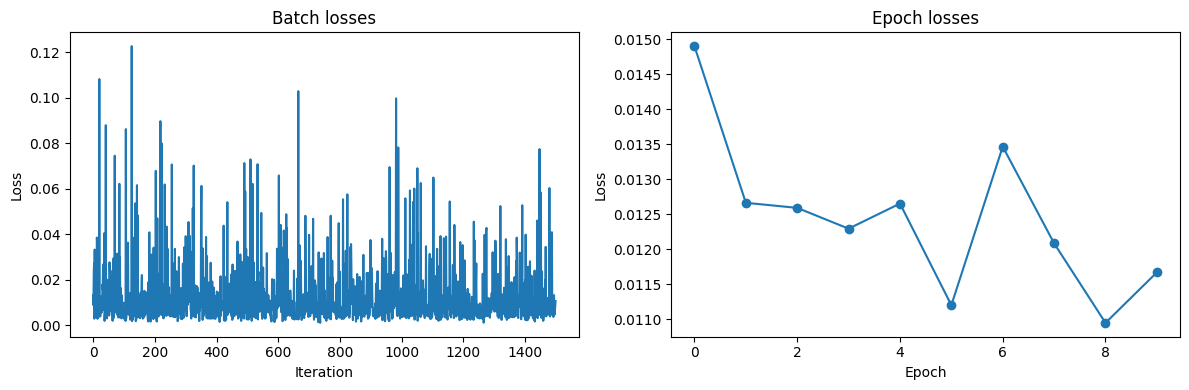

Model weights saved to: csrnet_weights.pth
Loss curves saved to: loss_curve.png and csrnet_losses.npz


In [77]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(batch_losses)
axs[0].set_title("Batch losses")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

axs[1].plot(epoch_losses, marker="o")
axs[1].set_title("Epoch losses")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)
plt.show()

torch.save(model.state_dict(), CFG.save_path)
np.savez(CFG.losses_path, batch_losses=np.array(batch_losses), epoch_losses=np.array(epoch_losses))

print(f"Model weights saved to: {CFG.save_path}")
print(f"Loss curves saved to: loss_curve.png and {CFG.losses_path}")


## 7. Training guidance and scaling

**Expected loss behavior**:
- Starts relatively high.
- Decreases over time, with some fluctuations.
- Should not explode or remain flat.

**Epoch recommendations**:
- ~50 epochs: early results.
- 100–150 epochs: reasonable performance.
- ~300 epochs: near paper-level performance (depending on setup).

On CPU, full training is slow. Use this notebook for correctness and small experiments; for serious training, move to a GPU environment with the same code.

## 8. Sanity checks and sample inference

We run the trained model on a few samples from Part A and Part B, visualize predicted density maps, and compare predicted counts with ground-truth sums.

Inference on Part A:
--------------------------------------------------------------------------------
Part A Sample: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\images\IMG_5.jpg
Original #points: 585.00
Downsampled GT density sum: 583.25
GT count (tensor sum): 583.25
Predicted count (sum): 404.58


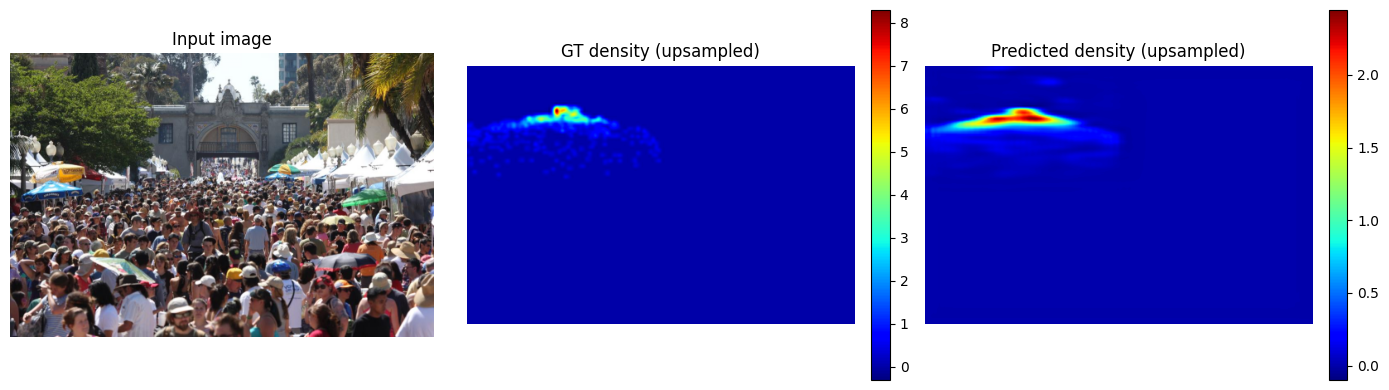

--------------------------------------------------------------------------------
Part A Sample: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_A\train_data\images\IMG_107.jpg
Original #points: 121.00
Downsampled GT density sum: 120.33
GT count (tensor sum): 120.33
Predicted count (sum): 93.94


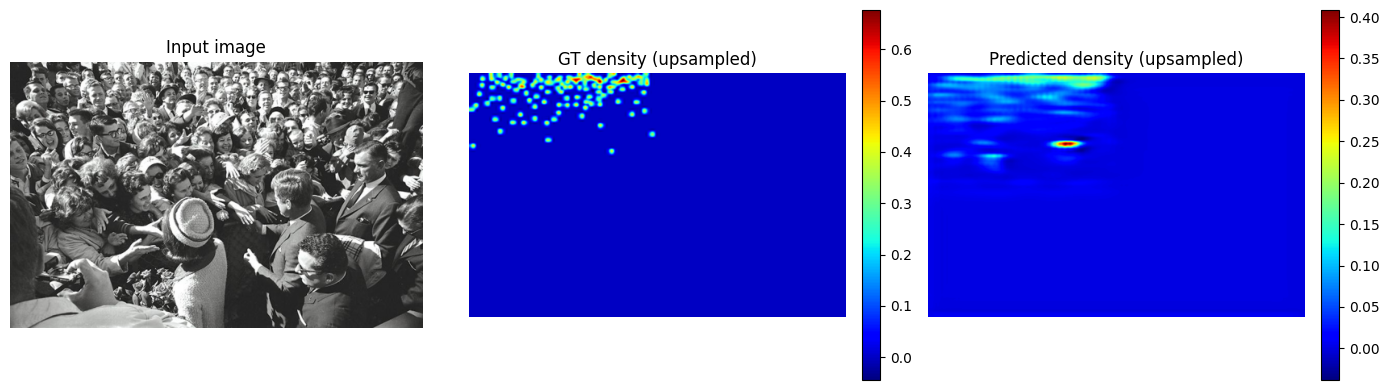


Inference on Part B:
--------------------------------------------------------------------------------
Part B Sample: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\images\IMG_174.jpg
Original #points: 173.00
Downsampled GT density sum: 171.88
GT count (tensor sum): 171.88
Predicted count (sum): 107.54


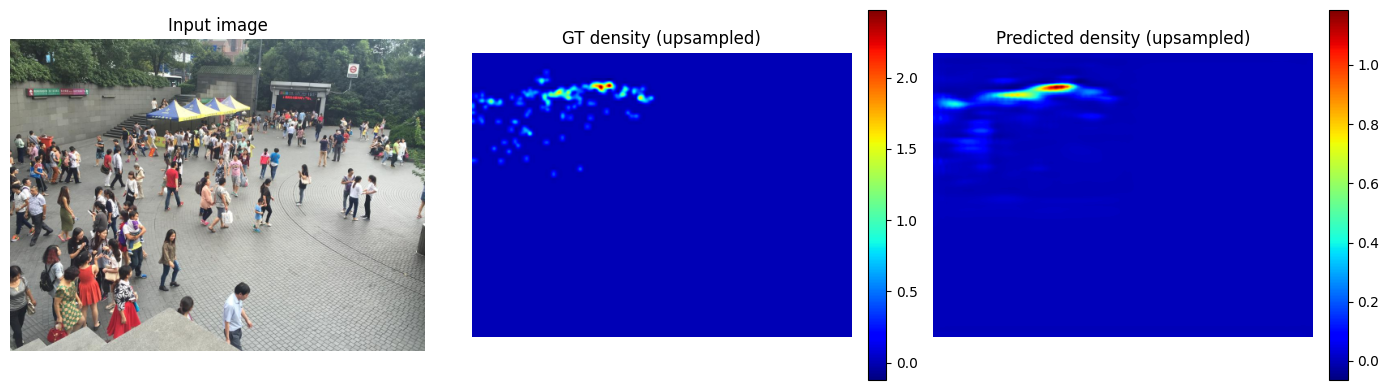

--------------------------------------------------------------------------------
Part B Sample: C:\Users\ARTI\OneDrive\Desktop\projects\cd\ShanghaiTech\part_B\train_data\images\IMG_368.jpg
Original #points: 130.00
Downsampled GT density sum: 122.14
GT count (tensor sum): 122.14
Predicted count (sum): 82.18


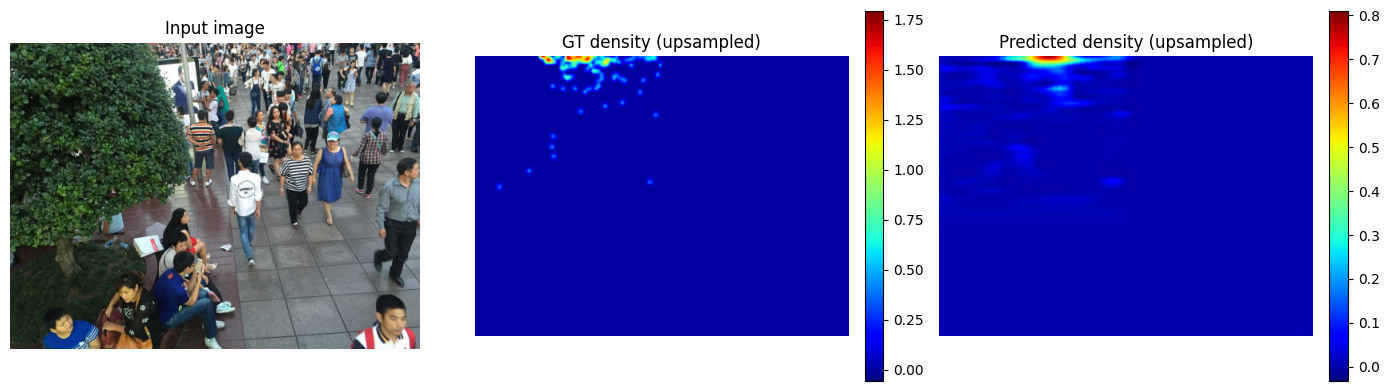

In [78]:

def run_inference_and_visualize(loader: DataLoader, title_prefix: str = "", max_batches: int = 1):
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            if batch_idx >= max_batches:
                break

            images = batch["image"].to(CFG.device)
            densities = batch["density"].to(CFG.device)
            metas = batch["meta"]

            outputs = model(images)
            b = images.size(0)

            for i in range(b):
                img_path = metas["img_path"][i]
                orig_count = metas["orig_count"][i]
                down_count = metas["down_count"][i]

                img_rgb_01, (h_new, w_new), _ = load_image_rgb_01(img_path, img_max_side=CFG.img_max_side)

                gt_dm = densities[i, 0].cpu().numpy()
                pred_dm = outputs[i, 0].cpu().numpy()

                gt_count = float(gt_dm.sum())
                pred_count = float(pred_dm.sum())

                print("-" * 80)
                print(f"{title_prefix} Sample: {img_path}")
                print(f"Original #points: {orig_count:.2f}")
                print(f"Downsampled GT density sum: {down_count:.2f}")
                print(f"GT count (tensor sum): {gt_count:.2f}")
                print(f"Predicted count (sum): {pred_count:.2f}")

                h_img, w_img, _ = img_rgb_01.shape
                gt_up = cv2.resize(gt_dm, (w_img, h_img), interpolation=cv2.INTER_CUBIC)
                pred_up = cv2.resize(pred_dm, (w_img, h_img), interpolation=cv2.INTER_CUBIC)

                fig, axs = plt.subplots(1, 3, figsize=(14, 4))
                axs[0].imshow(img_rgb_01)
                axs[0].set_title("Input image")
                axs[0].axis("off")

                im1 = axs[1].imshow(gt_up, cmap="jet")
                axs[1].set_title("GT density (upsampled)")
                axs[1].axis("off")
                fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                im2 = axs[2].imshow(pred_up, cmap="jet")
                axs[2].set_title("Predicted density (upsampled)")
                axs[2].axis("off")
                fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

                plt.tight_layout()
                plt.show()

print("Inference on Part A:")
run_inference_and_visualize(partA_train_loader, title_prefix="Part A", max_batches=1)

print("\nInference on Part B:")
run_inference_and_visualize(partB_train_loader, title_prefix="Part B", max_batches=1)


## 9. Final artifacts and cleanup

We confirm that weights and losses are saved and print a brief training summary.

In [79]:

print("Training complete on CPU.")
print(f"Saved CSRNet weights to: {CFG.save_path}")
print(f"Saved losses to: {CFG.losses_path}")

if len(epoch_losses) > 0:
    last_epoch_loss = epoch_losses[-1]
else:
    last_epoch_loss = float("nan")

print(f"Last epoch loss: {last_epoch_loss}")

Training complete on CPU.
Saved CSRNet weights to: csrnet_weights.pth
Saved losses to: csrnet_losses.npz
Last epoch loss: 0.011668326611785839


## 1. Evaluation Configuration

This cell sets test set locations, model weights, and device configuration.

In [80]:
# ---------------------- 
# 8. Evaluation Dataset 
# ----------------------

class ShanghaiTechEvalDataset(Dataset):
    def __init__(self, images_dir: str, gt_dir: str, img_max_side: int = None):
        self.images_dir = Path(images_dir)
        self.gt_dir = Path(gt_dir)
        self.img_max_side = img_max_side

        self.img_paths = sorted(self.images_dir.glob("*.jpg"))
        if len(self.img_paths) == 0:
            raise RuntimeError(f"No images found in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        mat_path = gt_mat_from_img(img_path, str(self.gt_dir))

        # Load image with resize (same as training)
        img_rgb_01, (h_new, w_new), scale = load_image_rgb_01(
            str(img_path), img_max_side=self.img_max_side
        )

        # Load points
        pts = load_points_from_mat(str(mat_path))
        pts_scaled = pts * scale

        # Generate density map
        dm_full = generate_density_from_points(pts_scaled, h_new, w_new)

        # PAD to fixed training size
        img_rgb_01, dm_full = pad_to_target_size(img_rgb_01, dm_full, TARGET_H, TARGET_W)

        # Downsample by 8
        dm_down = downsample_density_map(dm_full, factor=8)

        # Convert to tensors
        img_t = to_tensor_image(img_rgb_01)
        img_t = imagenet_normalize(img_t)
        dm_t = to_tensor_density(dm_down)

        return {
            "image": img_t,
            "gt_density": dm_t,
            "meta": {
                "img_path": str(img_path),
                "orig_points": float(len(pts)),
                "gt_count": float(dm_full.sum()),
                "gt_down_count": float(dm_down.sum()),
            },
        }


In [81]:
partA_test_images = CFG.partA_train_images.replace("train_data", "test_data")
partA_test_gt     = CFG.partA_train_gt.replace("train_data", "test_data")

partB_test_images = CFG.partB_train_images.replace("train_data", "test_data")
partB_test_gt     = CFG.partB_train_gt.replace("train_data", "test_data")

partA_test_loader = DataLoader(
    ShanghaiTechEvalDataset(partA_test_images, partA_test_gt, CFG.img_max_side),
    batch_size=1, shuffle=False
)

partB_test_loader = DataLoader(
    ShanghaiTechEvalDataset(partB_test_images, partB_test_gt, CFG.img_max_side),
    batch_size=1, shuffle=False
)

print("Part A test samples:", len(partA_test_loader.dataset))
print("Part B test samples:", len(partB_test_loader.dataset))


Part A test samples: 182
Part B test samples: 316


In [82]:
model = CSRNet(load_pretrained_vgg=False).to(CFG.device)

state = torch.load(CFG.save_path, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
print("Model loaded.")

Missing keys: []
Unexpected keys: []
Model loaded.


In [84]:
def evaluate(loader, label):
    model.eval()
    preds = []
    gts = []
    files = []

    print(f"\n--- Evaluating {label} ---")

    with torch.no_grad():
        for batch in loader:
            img = batch["image"].to(CFG.device)
            gt = batch["gt_density"].cpu().numpy()[0,0]

            pred = model(img)[0,0].cpu().numpy()

            preds.append(pred.sum())
            gts.append(gt.sum())
            files.append(batch["meta"]["img_path"][0])

    preds = np.array(preds)
    gts = np.array(gts)

    mae = np.mean(np.abs(preds - gts))
    rmse = np.sqrt(np.mean((preds - gts)**2))

    print(f"{label} MAE: {mae:.3f} | RMSE: {rmse:.3f}")
    return preds, gts, files

In [72]:
predA, gtA, filesA = evaluate(partA_test_loader, "Part A")
predB, gtB, filesB = evaluate(partB_test_loader, "Part B")


--- Evaluating Part A ---
Part A MAE: 150.682 | RMSE: 214.796

--- Evaluating Part B ---
Part B MAE: 33.509 | RMSE: 41.523


In [85]:
import numpy as np

def compute_all_metrics(preds, gts):
    """
    preds: array of predicted counts
    gts:   array of true counts
    """
    preds = np.array(preds, dtype=float)
    gts   = np.array(gts, dtype=float)

    mae  = np.mean(np.abs(preds - gts))
    rmse = np.sqrt(np.mean((preds - gts)**2))

    # accuracy: 1 - relative error
    accuracy = np.mean(1 - (np.abs(preds - gts) / (gts + 1e-6)))

    return mae, rmse, accuracy

In [86]:
maeA,  rmseA,  accA  = compute_all_metrics(predA, gtA)
maeB,  rmseB,  accB  = compute_all_metrics(predB, gtB)

print("=== Crowd Counting Evaluation Metrics ===\n")
print(f"Part A → MAE: {maeA:.2f}, RMSE: {rmseA:.2f}, Accuracy: {accA*100:.2f}%")
print(f"Part B → MAE: {maeB:.2f}, RMSE: {rmseB:.2f}, Accuracy: {accB*100:.2f}%")

=== Crowd Counting Evaluation Metrics ===

Part A → MAE: 150.68, RMSE: 214.80, Accuracy: 55.92%
Part B → MAE: 33.51, RMSE: 41.52, Accuracy: 60.17%


In [87]:
import pandas as pd

results_df = pd.DataFrame({
    "Dataset":   ["Part A", "Part B"],
    "MAE":       [maeA, maeB],
    "RMSE":      [rmseA, rmseB],
    "Accuracy%": [accA*100, accB*100]
})

print("\n=== Evaluation Summary Table ===")
results_df


=== Evaluation Summary Table ===


Dataset         MAE        RMSE  Accuracy%
0  Part A  150.681933  214.795718  55.919012
1  Part B   33.509201   41.523476  60.167372